Εδω χτίζω μοντέλο autoencoder με bottleneck που έχει το μισό αριθμό νευρώνων για input, το εκπαιδεύω και αποθηκεύω σε αρχείο το μοντέλο απο το bottleneck και πριν, δηλαδή μόνο το encoding τμήμα που θα κάνει μείωση των διαστάσεων (y=G1)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')
pd.options.display.float_format = '{:,.3f}'.format

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model

In [4]:
from tensorflow.keras.utils import plot_model

In [5]:
# load numpy array from npy file
from numpy import load
# load array
X = load('X_G1iter.npy') #data scaled with MinMaxScaaler and imputed with iterative imputer
y = load('y_G1.npy')

### prepare data fo model

In [14]:
# number of input columns
n_inputs = data.shape[1]-1 
print(n_inputs)

667


In [15]:
#load data and split to dependent and independent variables
X = data.loc[:, data.columns != 'G1'].values #select all but the desired one for y
y = data['G21'].values

#X and y are numpy ndarray type variables
print(X.shape,y.shape)

(1838, 667) (1838,)


In [16]:
X = np.array(X)
y = np.array(y)

In [17]:
# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=1)

In [18]:
print(X.shape,y.shape,X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(1838, 667) (1838,) (1470, 667) (1470,) (368, 667) (368,)


### Build layers

In [19]:
# define encoder
visible = Input(shape=(n_inputs,))
# encoder level 1
e = Dense(n_inputs*2)(visible)
e = BatchNormalization()(e)
e = LeakyReLU()(e)

In [20]:
# encoder level 2
e = Dense(n_inputs)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)

In [21]:
# bottleneck
n_bottleneck = round(float(n_inputs)/2.0)
bottleneck = Dense(n_bottleneck)(e)

In [22]:
# define decoder, level 1
d = Dense(n_inputs)(bottleneck)
d = BatchNormalization()(d)
d = LeakyReLU()(d)

In [23]:
# decoder level 2
d = Dense(n_inputs*2)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)

In [24]:
# output layer
output = Dense(n_inputs, activation='linear')(d)
# from keras documentation: Activation function to use (see activations). If you don't specify anything, no activation
#is applied (ie. "linear" activation: a(x) = x)
#δηλαδη ειναι σαν να μην εχει μπει activation function καθολου, λογικο καθως θελω να παρω το input ως output

### compile

In [25]:
# define autoencoder model
model = Model(inputs=visible, outputs=output)

In [26]:
# compile autoencoder model
#αν θελω και metrics οπως accuracy, πρεπει να το ορισω εδω, αλλιως μετα δεν επιστρεφονται στο evaluate
model.compile(optimizer='adam', loss='mse')

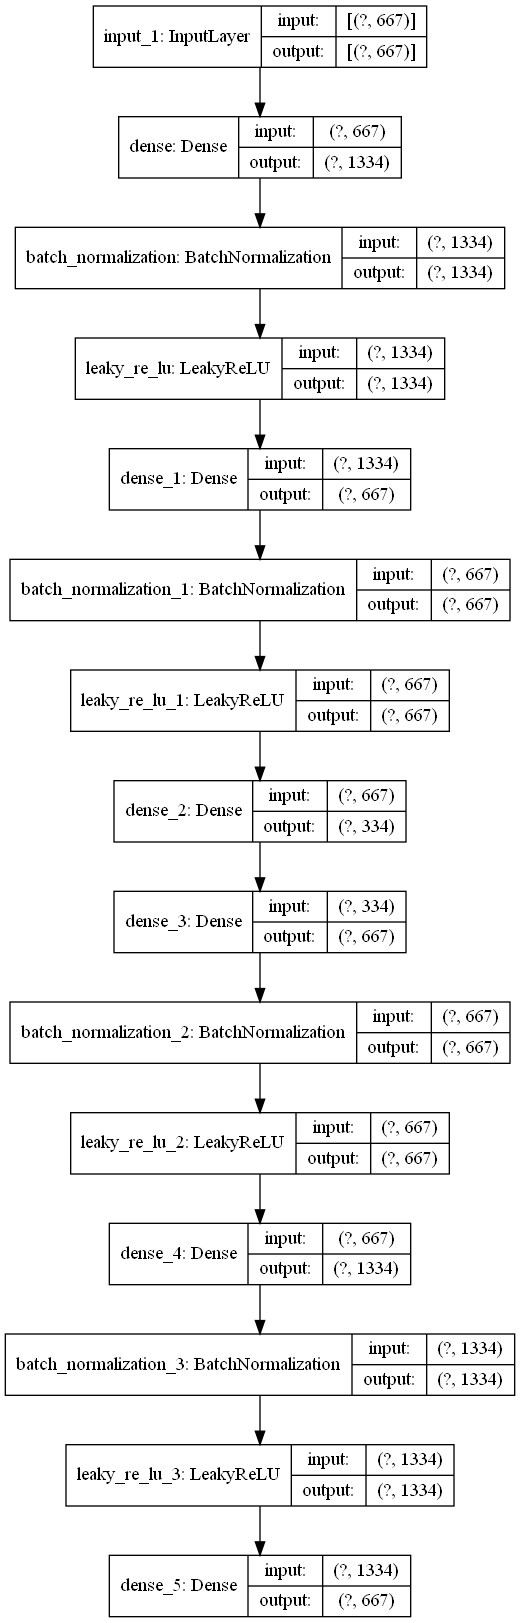

In [27]:
# plot the autoencoder
plot_model(model, 'autoencoder_compressG1.png', show_shapes=True)

### FIT

#### χρησιμοποιησα το validation split και οχι το validation_data, γτ φαινεται πως μαλλον το validation(Χ_test) και το training dataset (X_train)δεν ειναι το ιδιο αντιπροσωπευτικα 

In [28]:
history = model.fit(X_train,X_train, epochs=80, batch_size=16, verbose=2,validation_split=0.2)

Train on 1176 samples, validate on 294 samples
Epoch 1/80
1176/1176 - 5s - loss: 0.1405 - val_loss: 0.0799
Epoch 2/80
1176/1176 - 4s - loss: 0.0542 - val_loss: 0.0499
Epoch 3/80
1176/1176 - 4s - loss: 0.0493 - val_loss: 0.0450
Epoch 4/80
1176/1176 - 4s - loss: 0.0479 - val_loss: 0.0420
Epoch 5/80
1176/1176 - 4s - loss: 0.0444 - val_loss: 0.0439
Epoch 6/80
1176/1176 - 4s - loss: 0.0415 - val_loss: 0.0401
Epoch 7/80
1176/1176 - 4s - loss: 0.0385 - val_loss: 0.0397
Epoch 8/80
1176/1176 - 4s - loss: 0.0368 - val_loss: 0.0394
Epoch 9/80
1176/1176 - 4s - loss: 0.0351 - val_loss: 0.0361
Epoch 10/80
1176/1176 - 4s - loss: 0.0319 - val_loss: 0.0366
Epoch 11/80
1176/1176 - 4s - loss: 0.0312 - val_loss: 0.0333
Epoch 12/80
1176/1176 - 3s - loss: 0.0297 - val_loss: 0.0318
Epoch 13/80
1176/1176 - 4s - loss: 0.0280 - val_loss: 0.0332
Epoch 14/80
1176/1176 - 3s - loss: 0.0280 - val_loss: 0.0306
Epoch 15/80
1176/1176 - 4s - loss: 0.0261 - val_loss: 0.0297
Epoch 16/80
1176/1176 - 4s - loss: 0.0250 - val

In [29]:
# fit με ολο το dataset
#history = model.fit(X, X, epochs=120, batch_size=16, verbose=2,validation_split=0.2)

#### Evaluate με test set

##### The returned value of model.evaluate does contain loss and metrics. If it doesn't, the model wasn't compiled with metric, αλλα επισης μαλλον ισχυει: the accuracy function/metric in Keras is meant to be used with classification problems. It doesn't make any sense in this case. A better metric/loss is the mean squared error, because you're reconstructing the same features rather than predicting a class

In [30]:
model.evaluate(X_test, X_test,verbose=1)

#στο autoencoder απλα χρησιμοποιουμε το X_test και οχι y_test,καθως θελουμε να δουμε αν το εκανε reconstruct, δε θελουμε να
#βρουμε κλασεις οι οποιες βρισκονται στο y_test.
#To y_test το χωριζουμε απο πριν μαλλον για το classification, για να μην εκπαιδευθει μ αυτο

368/368 [==============================] - 0s 496us/sample - loss: 0.0160


0.01603403169175853

### plots for metrics

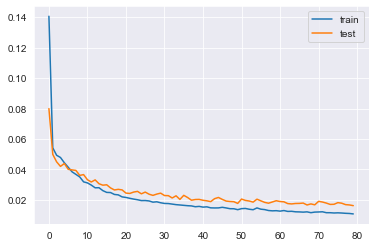

In [31]:
# plot 
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
#plt.plot(history.history['accuracy'], label='accuracy')
#plt.plot(history.history['mse'], label='mse') #to mse einai idio me to loss
plt.legend()
plt.show()

#Example of Train and Validation Learning Curves Showing an Overfit Model

#### define an encoder model (without the decoder) & save to file

In [33]:
# define an encoder model (without the decoder)
encoder = Model(inputs=visible, outputs=bottleneck)
plot_model(encoder, 'encoder_compressG1.png', show_shapes=True)
# save the encoder to file
encoder.save('encoder_halfG1.tf')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: encoder_halfG1.tf\assets
